The objective of this notebook is to intersect the sample metadata with the taxonomic profiling information to see the top 10, top 20, and top 25 groups for each individual over the time series of the sampling.

- load sample metadata
- order metadata by sample timestamp
- group sample metadata by participant
- for each participant, plot the relative abundances of their top 10, 20, and 25 taxons (at each level)

In [3]:
import Pkg
pkgs = [
    "Revise",
    "DataFrames",
    "StatsBase",
    "StatsPlots",
    "uCSV",
    "ProgressMeter",
    "Distances",
    "Clustering",
    "Colors",
    "MultivariateStats"
]
# Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end
import Mycelia

[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
[ Info: Precompiling GeoMakie [db073c08-6b98-4ee5-b6a4-5efafb3259c6]
[ Info: Precompiling GeometryBasicsExt [b238bd29-021f-5edc-8b0e-16b9cda5f63a]
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
[ Info: Precompiling Mycelia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
[ Info: Skipping precompilation since __precompile__(false). Importing Mycelia [453d265d-8292-4a7b-a57c-dce3f9ae6acd].
[ Info: Precompiling GraphRecipes [bd48cda9-67a9-57be-86fa-5b3c104eda73]
[ Info: Precompiling HTTP [cd3eb016-35fb-5094-929b-558a96fad6f3]
[ Info: Precompiling ForwardDiffStaticArraysExt [b74fd6d0-9da7-541f-a07d-1b6af30a262f]
[ Info: Precompiling FiniteDiffStaticArraysExt [75e56524-3a34-51de-85ea-03aa6eac4b64]
[ Info: Precompiling MetaGraphs [626554b9-1ddb-594c-aa3c-2596fe9399a5]


In [4]:
data_dir = joinpath(dirname(pwd()), "data")

"/oak/stanford/scg/lab_mpsnyder/cjprybol/Mycelia/projects/viral-exposome-discovery/data"

In [5]:
sample_paths = filter(x -> !occursin(".ipynb_checkpoints", x), readdir(joinpath(data_dir, "SRA"), join=true))

594-element Vector{String}:
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399459"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399460"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399461"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399462"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399463"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399464"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399465"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399466"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399467"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399468"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399469"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/

In [6]:
results_dir = joinpath(data_dir, "results")

"/oak/stanford/scg/lab_mpsnyder/cjprybol/Mycelia/projects/viral-exposome-discovery/data/results"

In [7]:
taxon_levels = Mycelia.list_ranks()

9-element Vector{String}:
 "top"
 "superkingdom"
 "kingdom"
 "phylum"
 "class"
 "order"
 "family"
 "genus"
 "species"

In [8]:
# i = 1
i = 2
# i = 3
# i = 4
# i = 5
# i = 6
# i = 7
# i = 8
# i = 9

(taxon_index, taxon_level) = collect(enumerate(taxon_levels))[i]
println("$(taxon_index) - $(taxon_level)")
rank_table = Mycelia.list_rank(taxon_level)

2 - superkingdom


Row,taxid,name
,Int64,String
1,10239,Viruses
2,2,Bacteria
3,2157,Archaea
4,2759,Eukaryota


In [ ]:
# NCBI host metadata
ncbi_metadata_file = joinpath(dirname(pwd()), "metadata", "NCBI-virus-refseq.transformed.tsv")
ncbi_host_metadata = DataFrames.DataFrame(uCSV.read(ncbi_metadata_file, header=1, delim='\t', encodings=Dict("false" => false, "true" => true)))

# ICTV host metadata
ictv_metadata_file = joinpath(dirname(pwd()), "metadata", "VMR_MSL38_v1 - VMR MSL38 v1.transformed.tsv")
ictv_host_metadata = DataFrames.DataFrame(uCSV.read(ictv_metadata_file, header=1, delim='\t', typedetectrows=100))
ictv_host_metadata = ictv_host_metadata[.!isempty.(ictv_host_metadata[!, "taxid"]), :]
ictv_host_metadata[!, "taxid"] = parse.(Int, ictv_host_metadata[!, "taxid"])

# # VirusHostDB metadata
virushostdb_metadata_file = joinpath(dirname(pwd()), "metadata", "virushostdb.transformed.tsv")
virushostdb_metadata = DataFrames.DataFrame(uCSV.read(virushostdb_metadata_file, header=1, delim='\t', typedetectrows=1086, encodings=Dict("missing" => missing, "false" => false, "true" => true)))

In [10]:
# get a list of all viral taxids across the databases

# filtered_tax_ids = Set(ictv_host_metadata[!, "taxid"])
# filtered_rank_table = rank_table[map(taxid -> taxid in filtered_tax_ids, rank_table[!, "taxid"]), :]

# println("$(taxon_index) - $(taxon_level)")
# rank_table = Mycelia.list_rank(taxon_level)
rank_taxids = Set(rank_table[!, "taxid"])

Set{Int64} with 4 elements:
  10239
  2759
  2
  2157

In [11]:
kraken_db = "k2_pluspfp"
kraken_db_regex = Regex("$(kraken_db)_\\d{8}")

r"k2_pluspfp_\d{8}"

In [12]:
cross_sample_taxon_report = joinpath(results_dir, "$(kraken_db).$(taxon_level).ictv.tsv")

"/oak/stanford/scg/lab_mpsnyder/cjprybol/Mycelia/projects/viral-exposome-discovery/data/results/k2_pluspfp.superkingdom.ictv.tsv"

In [13]:
cross_sample_taxon_figure_png = joinpath(results_dir, "$(kraken_db).$(taxon_level).ictv.png")

"/oak/stanford/scg/lab_mpsnyder/cjprybol/Mycelia/projects/viral-exposome-discovery/data/results/k2_pluspfp.superkingdom.ictv.png"

In [14]:
exposome_kraken_reports = map(path ->
    first(filter(x -> occursin(kraken_db_regex, x) && occursin(r"kraken-report\.tsv$", x), readdir(joinpath(path, "kraken"), join=true))),
    sample_paths)
# kraken_dirs = filter(x -> occursin(r"Kraken2", x), readdir(joinpath(data_dir, "ultimagen-snyder"), join=true))
# ultima_kraken_reports = reduce(vcat, [readdir(kraken_dir, join=true) for kraken_dir in kraken_dirs])
# ipop_kraken_reports = readdir(joinpath(data_dir, "ultimagen-snyder/ipop/kraken2"), join=true)
# joint_kraken_reports = vcat(exposome_kraken_reports, ultima_kraken_reports, ipop_kraken_reports)
joint_kraken_reports = exposome_kraken_reports

594-element Vector{String}:
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-

In [15]:
cross_sample_taxon_report_table = DataFrames.DataFrame()
# sample_path = first(sample_paths)
ProgressMeter.@showprogress for kraken_report in joint_kraken_reports
    report_table = Mycelia.read_kraken_report(kraken_report)
    taxon_level_report = report_table[map(x -> x in rank_taxids, report_table[!, "ncbi_taxonid"]), :]
    taxon_level_report[!, "sample_identifier"] .= basename(kraken_report)
    append!(cross_sample_taxon_report_table, taxon_level_report)
end
cross_sample_taxon_report_summary = cross_sample_taxon_report_table[!, DataFrames.Not(["percentage_of_fragments_at_or_below_taxon", "number_of_fragments_assigned_directly_to_taxon", "rank"])]
# uCSV.write(cross_sample_taxon_report, cross_sample_taxon_report_table, delim='\t')

Progress: 100%|█████████████████████████████████████████| Time: 0:02:14


Row,number_of_fragments_at_or_below_taxon,ncbi_taxonid,scientific_name,sample_identifier
,Int64,Int64,String,String
1,10606176,2759,Eukaryota,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv
2,1224652,2,Bacteria,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv
3,6051,2157,Archaea,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv
4,355,10239,Viruses,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv
5,19211279,2759,Eukaryota,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv
6,880980,2,Bacteria,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv
7,4331,2157,Archaea,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv
8,1766,10239,Viruses,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv
9,11722379,2759,Eukaryota,SRR6399461.k2_pluspfp_20221209.kraken-report.tsv


In [16]:
cross_sample_taxon_report_summary[!, "taxon"] = map(row -> string(row["ncbi_taxonid"]) * "_" * row["scientific_name"], DataFrames.eachrow(cross_sample_taxon_report_summary))
# cross_sample_taxon_report_summary = cross_sample_taxon_report_summary[!, DataFrames.Not([
#             "ncbi_taxonid",
#             "scientific_name"
#         ])]

2376-element Vector{String}:
 "2759_Eukaryota"
 "2_Bacteria"
 "2157_Archaea"
 "10239_Viruses"
 "2759_Eukaryota"
 "2_Bacteria"
 "2157_Archaea"
 "10239_Viruses"
 "2759_Eukaryota"
 "2_Bacteria"
 "2157_Archaea"
 "10239_Viruses"
 "2_Bacteria"
 ⋮
 "2759_Eukaryota"
 "2_Bacteria"
 "2157_Archaea"
 "10239_Viruses"
 "2759_Eukaryota"
 "2_Bacteria"
 "2157_Archaea"
 "10239_Viruses"
 "2759_Eukaryota"
 "2_Bacteria"
 "2157_Archaea"
 "10239_Viruses"

In [17]:
# assert sortedness & uniqueness (should be a no-op)
unique!(DataFrames.sort!(cross_sample_taxon_report_summary, ["sample_identifier", "taxon"]))

Row,number_of_fragments_at_or_below_taxon,ncbi_taxonid,scientific_name,sample_identifier,taxon
,Int64,Int64,String,String,String
1,355,10239,Viruses,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,10239_Viruses
2,6051,2157,Archaea,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,2157_Archaea
3,10606176,2759,Eukaryota,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,2759_Eukaryota
4,1224652,2,Bacteria,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,2_Bacteria
5,1766,10239,Viruses,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,10239_Viruses
6,4331,2157,Archaea,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,2157_Archaea
7,19211279,2759,Eukaryota,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,2759_Eukaryota
8,880980,2,Bacteria,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,2_Bacteria
9,1509,10239,Viruses,SRR6399461.k2_pluspfp_20221209.kraken-report.tsv,10239_Viruses


In [18]:
cross_sample_taxon_report_summary = cross_sample_taxon_report_summary[cross_sample_taxon_report_summary[!, "number_of_fragments_at_or_below_taxon"] .> 0, :]

Row,number_of_fragments_at_or_below_taxon,ncbi_taxonid,scientific_name,sample_identifier,taxon
,Int64,Int64,String,String,String
1,355,10239,Viruses,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,10239_Viruses
2,6051,2157,Archaea,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,2157_Archaea
3,10606176,2759,Eukaryota,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,2759_Eukaryota
4,1224652,2,Bacteria,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,2_Bacteria
5,1766,10239,Viruses,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,10239_Viruses
6,4331,2157,Archaea,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,2157_Archaea
7,19211279,2759,Eukaryota,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,2759_Eukaryota
8,880980,2,Bacteria,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,2_Bacteria
9,1509,10239,Viruses,SRR6399461.k2_pluspfp_20221209.kraken-report.tsv,10239_Viruses


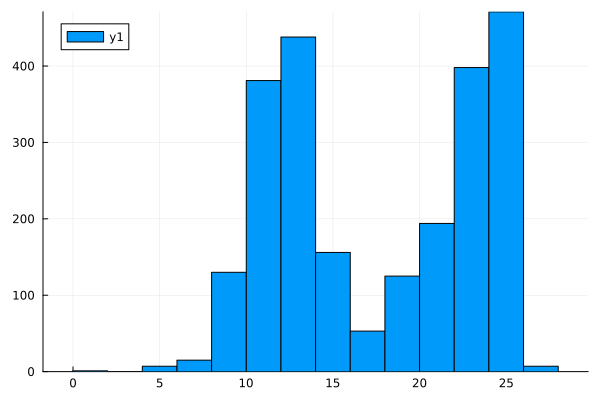

In [19]:
StatsPlots.histogram(log2.(cross_sample_taxon_report_summary[!, "number_of_fragments_at_or_below_taxon"]))

In [20]:
cross_sample_taxon_report_summary = cross_sample_taxon_report_summary[cross_sample_taxon_report_summary[!, "number_of_fragments_at_or_below_taxon"] .>= 3, :]

Row,number_of_fragments_at_or_below_taxon,ncbi_taxonid,scientific_name,sample_identifier,taxon
,Int64,Int64,String,String,String
1,355,10239,Viruses,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,10239_Viruses
2,6051,2157,Archaea,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,2157_Archaea
3,10606176,2759,Eukaryota,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,2759_Eukaryota
4,1224652,2,Bacteria,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,2_Bacteria
5,1766,10239,Viruses,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,10239_Viruses
6,4331,2157,Archaea,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,2157_Archaea
7,19211279,2759,Eukaryota,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,2759_Eukaryota
8,880980,2,Bacteria,SRR6399460.k2_pluspfp_20221209.kraken-report.tsv,2_Bacteria
9,1509,10239,Viruses,SRR6399461.k2_pluspfp_20221209.kraken-report.tsv,10239_Viruses


In [21]:
# load in metadata
metadata_dir = joinpath(dirname(pwd()), "metadata")

exposome_environmental_data = DataFrames.DataFrame(uCSV.read(
    joinpath(metadata_dir, "metadata_exposome.rds.tsv"),
    delim='\t',
    header=1,
    typedetectrows=300
))

joint_sample_metadata = DataFrames.DataFrame(uCSV.read(
    joinpath(metadata_dir, "exposome/joint_sample_metadata.tsv"),
    delim='\t',
    header=1,
    typedetectrows=300
))

@assert joint_sample_metadata[!, "Library Name"] == joint_sample_metadata[!, "LibraryName"]

joint_metadata = DataFrames.innerjoin(
    joint_sample_metadata,
    exposome_environmental_data,
    on="Library Name" => "samplenames")

In [26]:
# aownership
metadata_by_owner = DataFrames.groupby(joint_metadata, "aownership")

Row,Experiment Accession,Experiment Title,Organism Name,Instrument,Submitter,Study Accession,Study Title,Sample Accession,Sample Title,"Total Size, Mb",Total RUNs,Total Spots,Total Bases,Library Name,Library Strategy,Library Source,Library Selection,Run,ReleaseDate,LoadDate,spots,bases,spots_with_mates,avgLength,size_MB,AssemblyName,download_path,LibraryName,LibraryLayout,InsertSize,InsertDev,Platform,BioProject,Study_Pubmed_id,ProjectID,BioSample,SampleType,TaxID,g1k_pop_code,source,g1k_analysis_group,Subject_ID,Sex,Disease,Tumor,Affection_Status,Analyte_Type,Histological_Type,Body_Site,CenterName,Submission,dbgap_study_accession,Consent,RunHash,ReadHash,+access,+submission_date,+publication_date,+last_update,altitude,env_feature,collection_date,sample number,sample_type,env_biome,lat_lon,geo_loc_name,isolation source,host,env_material,location,geo,geo2,duration,date.month,date.start,date.end,season,particle,temperature,humid,weekend,aownership,latitude,longitude
,String,String,String,String,String,String,String,String,String,Float64,Int64,Int64,Int64,String,String,String,String,String,String,String,Int64,Int64,Int64,Int64,Int64,String,String,String,String,Int64,Int64,String,String,String,Int64,String,String,Int64,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,Int64,String,String,String,String,String,String,String,String,String,String,String,Int64,String,String,String,String,String,String,String,String,String,String
1,SRX3492741,DNA-seq of air samples,air metagenome,Illumina HiSeq 4000,Stanford University,SRP127288,Airborne exposures samples Raw sequence reads,SRS2776343,,7161.87,1,58285750,17136430544,chaoexpo67_I5,WGS,METAGENOMIC,MDA,SRR6399706,2018-09-20 00:09:39,2017-12-20 22:41:12,58285750,17136430544,58285750,294,7161,GCA_000001405.13,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos5/sra-pub-zq-14/SRR006/399/SRR6399706.sralite.1,chaoexpo67_I5,PAIRED,0,0,ILLUMINA,PRJNA421162,,421162,SAMN08215973,simple,655179,,,,,,,no,,,,,STANFORD UNIVERSITY,SRA640713,,public,A7D306A38C3D399BA83DE62FB6ABB8E1,F36CEBD819C2CC9B604A802F16E1314B,public,2017-12-20T15:50:13.253,2018-09-20T00:00:00.000,2021-02-28T05:15:11.191,51,air filter,2017-02-02,283,DNA,air filter,37.40988969 N 122.1593497 W,"USA:california,Palo Alto",missing,missing,air,Campus,uswest,Westcoast,2.403587963,1,2017-01-28,2017-02-02,winter,6.433836664,25.00845376,34.67120431,weekday,P1,37.40988969,-122.1593497
2,SRX3492740,DNA-seq of air samples,air metagenome,Illumina HiSeq 4000,Stanford University,SRP127288,Airborne exposures samples Raw sequence reads,SRS2776345,,6749.48,1,51048135,14967992451,chaoexpo67_I6,WGS,METAGENOMIC,MDA,SRR6399707,2018-09-20 00:09:39,2017-12-20 23:30:31,51048135,14967992451,51048135,293,6749,GCA_000001405.13,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos5/sra-pub-zq-14/SRR006/399/SRR6399707.sralite.1,chaoexpo67_I6,PAIRED,0,0,ILLUMINA,PRJNA421162,,421162,SAMN08215972,simple,655179,,,,,,,no,,,,,STANFORD UNIVERSITY,SRA640713,,public,F7C637A0ECA050584FDD0B5EAB344209,4E7EC27C92CEE1C8DE1265D86B4E6F9C,public,2017-12-20T15:50:13.240,2018-09-20T00:00:00.000,2021-02-28T05:15:11.060,5,air filter,2017-01-27,282,DNA,air filter,29.272251 N 94.818915 W,"USA:texas,Galveston",missing,missing,air,Houston-TX,uswest,Southwest,2.953472222,1,2017-01-24,2017-01-27,winter,4.387703582,24.65875088,39.45660318,weekday,P1,29.272251,-94.818915
3,SRX3492739,DNA-seq of air samples,air metagenome,Illumina HiSeq 4000,Stanford University,SRP127288,Airborne exposures samples Raw sequence reads,SRS2776338,,7797.92,1,87571718,25550913488,chaoexpo67_I15,WGS,METAGENOMIC,MDA,SRR6399708,2018-09-20 00:09:39,2017-12-21 23:57:29,87571718,25550913488,87571718,291,7797,GCA_000001405.13,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos5/sra-pub-zq-14/SRR006/399/SRR6399708.sralite.1,chaoexpo67_I15,PAIRED,0,0,ILLUMINA,PRJNA421162,,421162,SAMN08215971,simple,655179,,,,,,,no,,,,,S

In [ ]:
# weekend
# temperature
# humid
# season
# particle

# geo_loc_name

# # average duration?
# duration
# date.start
# date.end

In [ ]:
# if level == 9
# taxon_report_summary_with_host_info = DataFrames.innerjoin(
#     cross_sample_taxon_report_summary,
#     ictv_host_metadata,
#     on="ncbi_taxonid" => "taxid")

In [ ]:
colorscheme = Colors.distinguishable_colors(length(hosts), [Colors.RGB(1,1,1), Colors.RGB(0,0,0)], dropseed=true)

In [ ]:
normalized_values = values ./ sum(values, dims=2)

In [ ]:
distance_matrix = Distances.pairwise(Distances.Euclidean(), normalized_values, dims=1)
clustering = Clustering.hclust(distance_matrix, branchorder=:optimal)

In [ ]:
bottommargin = (maximum(length.(samples)) * 5)
leftmargin = 150
rightmargin = 25
topmargin = 25

width = max(1920, (length(samples) * 10) + 300)
height = max(1080, bottommargin + 600)
height = max(height, length(hosts)*11)

plot = StatsPlots.groupedbar(
    log10.(values),
    title = "read-classification - kraken - $(kraken_db) - $(taxon_level)",
    titlefontsize = 12,
    xticks = (1:length(samples), samples),
    xlims = (0, length(samples)+1),
    xtickfontsize = 6,
    size= (width, height),
    xrotation=90,
    ylabel = "log10(number of reads)",
    labels = hcat(hosts...),
    leftmargin = (leftmargin)StatsPlots.Plots.PlotMeasures.px,
    topmargin = (topmargin)StatsPlots.Plots.PlotMeasures.px,
    rightmargin = (rightmargin)StatsPlots.Plots.PlotMeasures.px,
    bottommargin = (bottommargin)StatsPlots.Plots.PlotMeasures.px,
    legendmargins = 0,
    legend = :outertopright,
    legendfontsize = 6,
    bar_position = :stack,
    bar_width=0.7,
    seriescolor = hcat(reverse(colorscheme)...),
)
# display(plot)
for extension in [".png"]
    file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(kraken_db).$(taxon_index).$(taxon_level).by-host.ictv.total-reads") * extension
    StatsPlots.savefig(plot, file)
end

In [ ]:
plot = StatsPlots.groupedbar(
    normalized_values,
    title = "read-classification - kraken - $(kraken_db) - $(taxon_level)",
    titlefontsize = 12,
    xticks = (1:length(samples), samples),
    xlims = (0, length(samples)+1),
    xtickfontsize = 6,
    size= (width, height),
    xrotation=90,
    ylabel = "proportion of reads",
    labels = hcat(hosts...),
    leftmargin = (leftmargin)StatsPlots.Plots.PlotMeasures.px,
    topmargin = (topmargin)StatsPlots.Plots.PlotMeasures.px,
    rightmargin = (rightmargin)StatsPlots.Plots.PlotMeasures.px,
    bottommargin = (bottommargin)StatsPlots.Plots.PlotMeasures.px,
    legendmargins = 0,
    legend = :outertopright,
    bar_position = :stack,
    bar_width=0.7,
    seriescolor = hcat(reverse(colorscheme)...),
    legendfontsize = 6,
)

# for extension in [".png", ".svg"]
for extension in [".png"]
    file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(kraken_db).$(taxon_index).$(taxon_level).by-host.ictv.normalized-reads") * extension
    StatsPlots.savefig(plot, file)
end

In [ ]:
################################################################################################
distance_matrix = Distances.pairwise(Distances.Euclidean(), normalized_values, dims=1)
clustering = Clustering.hclust(distance_matrix, branchorder=:optimal)
cluster_plot = StatsPlots.plot(
    clustering,
    xlims = (0, length(samples)+1),
    title = "read-classification - kraken - $(kraken_db) - $(taxon_level)",
    titlefontsize = 12,
    bottommargin = 0StatsPlots.Plots.PlotMeasures.px,
    leftmargin = (leftmargin)StatsPlots.Plots.PlotMeasures.px,
    rightmargin = (rightmargin)StatsPlots.Plots.PlotMeasures.px,
    topmargin = (topmargin)StatsPlots.Plots.PlotMeasures.px,
    xticks = false,
    yticks = false,
    yaxis = false,
    xaxis = false
)
taxonomy_plot = StatsPlots.groupedbar(
    normalized_values[clustering.order, :],
    bar_position = :stack,
    leftmargin = (leftmargin)StatsPlots.Plots.PlotMeasures.px,
    topmargin = 0StatsPlots.Plots.PlotMeasures.px,
    rightmargin = (rightmargin)StatsPlots.Plots.PlotMeasures.px,
    bottommargin = (bottommargin)StatsPlots.Plots.PlotMeasures.px,
    legendmargins = 0,
    xticks = (1:length(samples), samples[clustering.order]),
    xtickfontsize = 4,
    xrotation=90,
    xlims = (0, length(samples)+1),
    size= (width, height),
    ylabel = "proportion of reads",
    seriescolor = hcat(reverse(colorscheme)...),
    legend = false,
    labels = hcat(hosts...),
    legendfontsize = 6,
)

plot = StatsPlots.plot(
    cluster_plot,
    taxonomy_plot,
    margins = 0StatsPlots.Plots.PlotMeasures.px,
    layout=StatsPlots.grid(2,1, heights=[0.2,0.8])
)
# # display(plot)
# # for extension in [".png", ".svg"]
for extension in [".png"]
    file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(kraken_db).$(taxon_index).$(taxon_level).normalized-reads.by-host.ictv.clustered") * extension
    StatsPlots.savefig(plot, file)
end

In [ ]:
# result = 2
# Mycelia.fit_optimal_number_of_clusters(distance_matrix)
# clustering_assignments = Clustering.cutree(clustering, k=2)
clustering_assignments = Clustering.kmeans(distance_matrix, 2).assignments
# to skip clustering
# clustering_assignments = ones(Int, size(distance_matrix, 1))

In [ ]:
# sample_groups = [String[], String[]]
# for (cluster, sample) in zip(clustering_assignments, samples)
#     push!(sample_groups[cluster], sample)
# end
# sample_groups

In [ ]:
StatsPlots.plotly()

In [ ]:
fit_pca = MultivariateStats.fit(MultivariateStats.PCA, normalized_values')
transformed_observations = MultivariateStats.transform(fit_pca, normalized_values')

top_level_groups = unique(clustering_assignments)
# Colors.RGB(0,0,0), Colors.RGB(0.78, 0.129, 0.867)
colorscheme = Colors.distinguishable_colors(length(top_level_groups), [Colors.RGB(1,1,1), Colors.RGB(0,0,0), Colors.RGB(0.78, 0.129, 0.867)], dropseed=true)
xs = [Float64[] for group in top_level_groups]
ys = [Float64[] for group in top_level_groups]
zs = [Float64[] for group in top_level_groups]

raw_xs = transformed_observations[1, :]
if size(transformed_observations, 1) >= 2
    raw_ys = transformed_observations[2, :]
else
    raw_ys = zeros(length(raw_xs))
end

if size(transformed_observations, 1) >= 3
    raw_zs = transformed_observations[3, :]
else
    raw_zs = zeros(length(raw_xs))
end

for (i, (x, y, z)) in enumerate(zip(raw_xs, raw_ys, raw_zs))
    # @show sample, x, y
    # sample_groups = findall(x -> occursin(x, sample), top_level_groups)
    # @assert length(sample_groups) == 1
    # sample_group = first(sample_groups)
    
    push!(xs[clustering_assignments[i]], x)
    push!(ys[clustering_assignments[i]], y)
    push!(zs[clustering_assignments[i]], z)
end

plot = 
StatsPlots.scatter(
    xs,
    ys,
    zs,
    xlabel = "PC1",
    ylabel = "PC2",
    zlabel = "PC3",
    # labels = hcat(top_level_groups...),
    title = "read-classification - kraken - $(kraken_db) - by host",
    titlefontsize = 10,
    # legend = :outertopright,
    legend = false,
    size = (640, 480),
    margins = 20StatsPlots.px,
    seriescolor = hcat(colorscheme...)
)

display(plot)
# for extension in [".png"]
#     file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(kraken_db).$(taxon_index).$(taxon_level).pca") * extension
#     StatsPlots.savefig(plot, file)
# end

In [ ]:
fit_pca = MultivariateStats.fit(MultivariateStats.PCA, normalized_values')
transformed_observations = MultivariateStats.transform(fit_pca, normalized_values')

top_level_groups = unique(clustering_assignments)
# Colors.RGB(0,0,0), Colors.RGB(0.78, 0.129, 0.867)
colorscheme = Colors.distinguishable_colors(length(top_level_groups), [Colors.RGB(1,1,1), Colors.RGB(0,0,0), Colors.RGB(0.78, 0.129, 0.867)], dropseed=true)
xs = [Float64[] for group in top_level_groups]
ys = [Float64[] for group in top_level_groups]
zs = [Float64[] for group in top_level_groups]

raw_xs = transformed_observations[1, :]
if size(transformed_observations, 1) >= 2
    raw_ys = transformed_observations[2, :]
else
    raw_ys = zeros(length(raw_xs))
end

if size(transformed_observations, 1) >= 3
    raw_zs = transformed_observations[3, :]
else
    raw_zs = zeros(length(raw_xs))
end

for (i, (x, y, z)) in enumerate(zip(raw_xs, raw_ys, raw_zs))
    # @show sample, x, y
    # sample_groups = findall(x -> occursin(x, sample), top_level_groups)
    # @assert length(sample_groups) == 1
    # sample_group = first(sample_groups)
    
    push!(xs[clustering_assignments[i]], x)
    push!(ys[clustering_assignments[i]], y)
    push!(zs[clustering_assignments[i]], z)
end

plot = 
StatsPlots.scatter(
    xs,
    ys,
    zs,
    xlabel = "PC1",
    ylabel = "PC2",
    zlabel = "PC3",
    # labels = hcat(top_level_groups...),
    title = "read-classification - kraken - $(kraken_db) - by host",
    titlefontsize = 10,
    # legend = :outertopright,
    legend = false,
    size = (640, 480),
    margins = 20StatsPlots.px,
    seriescolor = hcat(colorscheme...)
)

display(plot)
# for extension in [".png"]
#     file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(kraken_db).$(taxon_index).$(taxon_level).pca") * extension
#     StatsPlots.savefig(plot, file)
# end

In [ ]:
# # need to tune this to be proportional to the # of taxa in the list
# aspect_ratio = [9, 40]
# scale = 500
# plot = StatsPlots.groupedbar(
#     normalized_values,
#     title = "read-classification - $(taxon_level)",
#     xticks = (1:length(samples), samples),
#     xlims = (0, length(samples)+1),
#     xtickfontsize = 6,
#     size= aspect_ratio .* scale,
#     xrotation=90,
#     ylabel = "proportion of reads",
#     labels = hcat(taxa...),
#     margins = 100StatsPlots.Plots.PlotMeasures.px,
#     legend = :outertopright,
#     bar_position = :stack,
#     bar_width=0.7,
#     seriescolor = hcat(reverse(colorscheme)...),
#     legendfontsize = 6,
# )

# for extension in [".png", ".svg"]
#     file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(taxon_index).$(taxon_level).normalized-reads") * extension
#     StatsPlots.savefig(plot, file)
# end

In [ ]:
# aspect_ratio = [2, 1]
# scale = 1000

# cluster_plot = StatsPlots.plot(
#     clustering,
#     xlims = (1, length(samples)),
#     title = "read-classification - $(taxon_level)",
#     xticks = false,
#     yticks = false,
#     yaxis = false
# )
# taxonomy_plot = StatsPlots.groupedbar(
#     normalized_values[clustering.order, :],
#     bar_position = :stack,
#     bottommargin = 50StatsPlots.Plots.PlotMeasures.px,
#     leftmargin = 50StatsPlots.Plots.PlotMeasures.px,
#     xticks = (1:length(samples), samples[clustering.order]),
#     xtickfontsize = 4,
#     xrotation=90,
#     xlims = (0, length(samples)+1),
#     size= aspect_ratio .* scale,
#     ylabel = "proportion of reads",
#     seriescolor = hcat(reverse(colorscheme)...),
#     # bar_width=0.7,
#     legend = false,
#     labels = hcat(taxa...),
#     legendfontsize = 6,
# )

# # Create a separate subplot as a legend
# # legend_plot = StatsPlots.groupedbar(normalized_values[clustering.order, :], legend=true)
# # plot!(legend_subplot, label="Series 1", legend=:best, linecolor=1)
# # plot!(legend_subplot, label="Series 2", legend=:best, linecolor=2)

# # Layout the main plot and the legend subplot
# # l = @layout [a{0.7w}; b{0.3w}]
# # plot(p, legend_subplot, layout=l)

# plot = StatsPlots.plot(
#     cluster_plot, 
#     taxonomy_plot,
#     layout=StatsPlots.grid(2,1, heights=[0.2,0.8])
# )
# # display(plot)
# for extension in [".png", ".svg"]
#     file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(taxon_index).$(taxon_level).normalized-reads.clustered") * extension
#     StatsPlots.savefig(plot, file)
# end
# # end

In [ ]:
# for g in DataFrames.groupby(cross_sample_taxon_report_table, "sample_identifier")
#     # @show sum(g[!, "percentage_of_fragments_at_or_below_taxon"])
#     if sum(g[!, "percentage_of_fragments_at_or_below_taxon"]) == 100
#     else
#         identifier = g[1, "sample_identifier"]
#         println("\"$(identifier)\",")
#     end
# end

In [ ]:
# [number_of_fragments_at_or_below_taxon	ncbi_taxonid	scientific_name	sample_identifier

In [ ]:

# Mycelia.list_rank("kingdom")
# Mycelia.list_rank("phylum")
# Mycelia.list_rank("class")
# Mycelia.list_rank("order")
# Mycelia.list_rank("family")
# Mycelia.list_rank("genus")
# Mycelia.list_rank("species")

- loop through the above
- make a matrix where each row is a taxon rank and each column is a dataset
- make stacked barplots for each sample
- run PCA and k-means cluster to find meaningful groups
- repeat for mmseqs protein and blast nt